# <a href="https://miptstats.github.io/courses/ad_fivt.html">Введение в анализ данных</a>
## Домашнее задание 4. Нейронные сети.


**Правила, <font color="red">прочитайте внимательно</font>:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds24_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. **Работы, присланные иным способом, не принимаются.**
* Дедлайн см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*

**Правила оформления теоретических задач:**

* Решения необходимо прислать одним из следующих способов:
  * фотографией в правильной ориентации, где все четко видно, а почерк разборчив,
    * отправив ее как файл боту вместе с ноутбуком *или*
    * вставив ее в ноутбук посредством `Edit -> Insert Image`;
  * в виде $LaTeX$ в markdown-ячейках.
* Решения не проверяются, если какое-то требование не выполнено. Особенно внимательно все проверьте в случае выбора второго пункта (вставки фото в ноутбук). <font color="red"><b>Неправильно вставленные фотографии могут не передаться при отправке.</b></font> Для проверки попробуйте переместить `ipynb` в другую папку и открыть его там.
* В решениях поясняйте, чем вы пользуетесь, хотя бы кратко. Например, если пользуетесь независимостью, то достаточно подписи вида "*X и Y незав.*"
* Решение, в котором есть только ответ, и отсутствуют вычисления, оценивается в 0 баллов.





**Баллы за задание:**

<b><font color="blue">Легкая часть</font></b> (достаточно на "хор"):
* Задача 1 &mdash; 60 баллов
* Задача 2 &mdash; 30 баллов

<b><font color="orange">Сложная часть</font></b> (необходимо на "отл"):
* Задача 3 &mdash; 60 баллов


In [1]:
# Bot check

# HW_ID: fpmi_ad4
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [2]:
import numpy as np
import scipy.stats as sps
from numba import jit, cuda

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import torch
from torch import nn

sns.set(font_scale=1.2, palette='Set2')
%matplotlib inline

Перед выполнением задания обязательно посмотрите <a href="https://miptstats.github.io/courses/ad_fivt/lecture4.pdf" target="_blank">презентацию</a> и <a href="https://miptstats.github.io/courses/ad_fivt/nn_simple_examples.html" target="_blank">обучающий ноутбук</a> с занятия по нейронным сетям.

---
### <font color="blue"><i>Легкая часть</i></font>

---
### Задача 1.

Рассмотрим двухслойную нейронную сеть, которая принимает на вход $x\in\mathbb{R}$ и возвращает $y\in\mathbb{R}$. Выход первого слоя возвращает $u \in\mathbb{R}^2$. После первого слоя используется функция активации $\sigma(x) = \frac{1}{1 + \exp(-x)}$, после второго слоя функция активации не используется (или используется тождественная). Тем самым нашу нейронную можно представить в виде

$$\widehat{y}(x) = \sum_{h=1}^2 w_{2h}u_h(x) + b_2,$$

$$u_h(x) = \sigma(w_{1h}x + b_{1h}),$$"

$$\text{где} \; h \in \{1, 2\}.$$



**1.** Нарисуйте схематически данную нейронную сеть. Сколько у нее обучаемых параметров?

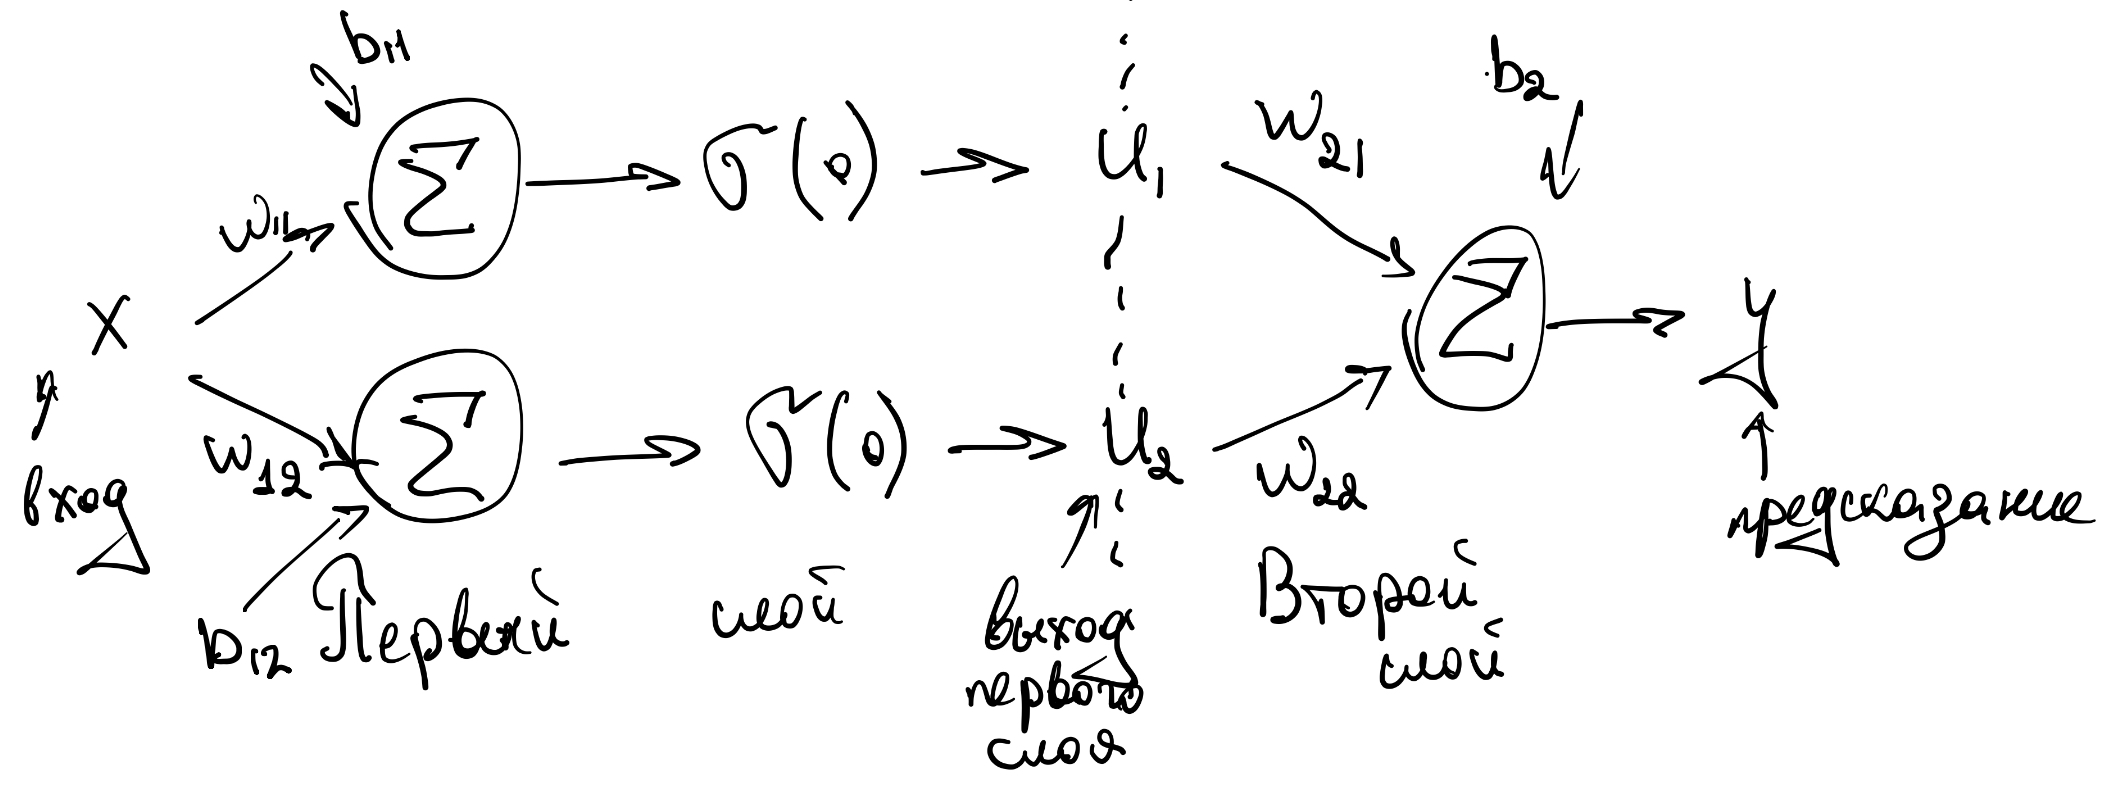

Обучаемых параметров получаем $7: w_{11}, w_{12}, w_{21}, w_{22}, b_{11}, b_{12}, b_2$

**2.** Пусть нам дана обучающая выборка $(X_1, Y_1), ..., (X_n, Y_n)$, где $X_i \in \mathbb{R}$ и $Y_i \in \mathbb{R}$. Нейронная сеть обучается по этой выборке, минимизируя заданную функцию $L$ &mdash; функцию ошибки. Положим, что $L$ &mdash; это MSE:
$$\text{MSE} = L(X, Y) = \frac{1}{n}\sum_{i=1}^n \big(Y_i - \widehat{y}(X_i)\big)^2.$$

Наша задача &mdash; найти оптимальные параметры нашей модели для минимизации $L(X, Y)$ на заданном наборе данных. Мы будем решать эту задачу с помощью градиентного спуска. Для этого нам понадобится выписать производные по всем параметрам сети. Конечно, в данном случае довольно просто выписать все производные напрямую. Однако мы воспользуемся следующей хитростью: мы будем считать производные поэтапно, причем начнем с конца вычислительной цепочки и, используя формулу производной сложной функции, последовательно посчитаем все необходимые производные. Этот процесс называется методом **обратного распространения ошибки (backpropagation)**.

**2.1.** Начнем с производной MSE по выходам сети
$$\frac{\partial\:\text{MSE}}{\partial \widehat{y}(X_i)} = -2 \cdot \frac{1}{n} \sum_{i=1}^n (Y_i - \widehat{y}(X_i)). $$

**2.2** Возьмем производные выходов сети по параметрам последнего слоя

$$\frac{\partial \widehat{y}(X_i)}{\partial w_{2h}} = u_h(X_i).$$

$$\frac{\partial \widehat{y}(X_i)}{\partial b_2} = 1.$$

Также выпишем производные выходов сети по входам последнего слоя

$$\frac{\partial \widehat{y}(X_i)}{\partial u_h(X_i)} = w_{2h}.$$

Теперь выпишем производные MSE по параметрам и входам последнего слоя. Для этого вспомните правило производной сложной функции из математического анализа. Обратите внимание на то, что нам не нужно прописывать все производные до конца, достаточно заполнить пропуски в записи ниже:

$$\frac{\partial\:\text{MSE}}{\partial w_{2h}} = \sum_{i=1}^n \frac{\partial\:\text{MSE}}{\partial \widehat{y}(X_i)} \frac{\partial \widehat{y}(X_i)}{\partial w_{2h}}$$


$$\frac{\partial\:\text{MSE}}{\partial b_2} = \sum_{i=1}^n \frac{\partial\:\text{MSE}}{\partial \widehat{y}(X_i)} \cdot \frac{\partial \widehat{y}(X_i)}{\partial b_2} $$

$$\frac{\partial\:\text{MSE}}{\partial u_h} = \sum_{i=1}^n \frac{\partial\:\text{MSE}}{\partial \widehat{y}(X_i)} \cdot \frac{\partial \widehat{y}(X_i)}{\partial u_h(X_i)}$$

**2.2.** Теперь будем разбираться с производными по параметрам первого слоя.

Для начала нам пригодится производная функции активации, запишите ее так, чтобы ответе осталась функция от $\sigma(x)$

$$\frac{\partial\:\sigma(x)}{\partial x} = \sigma(x)(1 - \sigma(x)).$$

Теперь возьмем производные выходов первого слоя по его параметрам

$$\frac{\partial u_h(X_i)}{\partial w_{1h}} = \sigma'(w_{1h}X_i + b_{1h})X_i.$$

$$\frac{\partial u_h(X_i)}{\partial b_{1h}} = \sigma'(w_{1h}X_i + b_{1h}).$$

Наконец, выпишем производные MSE по параметрам первого слоя. Так же как и раньше достаточно заполнить пропуски в записи ниже

$$\frac{\partial\:\text{MSE}}{\partial w_{1h}} = \; \sum_{i=1}^n \frac{\partial\:\text{MSE}}{\partial u_h(X_i)} \frac{\partial u_h(X_i)}{\partial w_{1h}}$$

$$\frac{\partial\:\text{MSE}}{\partial b_{1h}} = \; \sum_{i=1}^n \frac{\partial\:\text{MSE}}{\partial u_h(X_i)} \frac{\partial u_h(X_i)}{\partial b_{1h}}$$


**3.** Пусть обучающая выборка очень большая. Что нужно делать в таком случае? Запишите, как нужно поменять правило обновления параметров.

Когда обучающая выборка очень большая, стандартный градиентный спуск может быть вычислительно затратным. В таких случаях часто используются различные вариации стохастического градиентного спуска, которые обновляют параметры модели по частям данных.

Одна из таких вариаций - это Mini-batch Gradient Descent. При использовании Mini-batch Gradient Descent данные разбиваются на небольшие подмножества, называемые "mini-batches". Затем параметры модели обновляются с использованием градиента, рассчитанного на каждом батче. Это позволяет уменьшить вычислительную нагрузку и обновлять параметры модели более часто.

Правило обновления параметров для Mini-batch Gradient Descent:

Выбрать размер батча $m$.
Разделить обучающую выборку на батчи.

Для каждого батча $B$:

Вычислить градиент функции потерь по параметрам на текущем батче.
Обновить параметры модели в направлении антиградиента с использованием выбранного метода оптимизации.
Правило обновления параметров для каждого батча выглядит следующим образом:
$$\theta = \theta - \alpha \nabla_{\theta} L(\theta; B)$$
где:

$\theta$ - параметры модели,
$\alpha$ - скорость обучения (learning rate),
$\nabla_{\theta} L(\theta; B)$ - градиент функции потерь.

Таким образом, для каждого батча мы вычисляем градиент и обновляем параметры модели. Этот процесс повторяется до тех пор, пока не будет достигнуто условие остановки (например, определенное количество эпох или достижение минимального значения функции потерь).

**Вывод:**
Нейронные сети состоят из разных слоев и различных функций активации. В задании мы рассмотрели двухслойную нейросеть с одной функцией активации между первым и вторым слоем. Для нее посчитали градиент, а после разобрали проблему большого размера выборки.

---
### Задача 2.

Напишите нейронную сеть из задачи 1 с помощью библиотеки `pytorch`, используя Sequential-стиль. Перед выполнением задачи рекомендуется посмотреть <a href="https://miptstats.github.io/courses/ad_fivt/nn_simple_examples.html#3.-Готовые-модули-из-PyTorch" target="_blank">ноутбук</a> с занятия. Функция активации реализована как `torch.nn.Sigmoid`.

*Внимание.* Для выполнения задачи потребуется установить библиотеку `pytorch`. Альтернативный вариант &mdash; выполнение в <a href="https://colab.research.google.com" target="_blank">Google Colab</a>. Учитывайте, что при длительном бездействии Colab может сам завершить работу ядра.

In [3]:
torch_model = nn.Sequential(
    # кол-во признаков во входном слое 1, в выходном 2
    nn.Linear(in_features=1, out_features=2),

    nn.Sigmoid(),
    # кол-во признаков во входном слое 2, в выходном 1
    nn.Linear(in_features=2, out_features=1)
)

# Проверяем слои в моделе
torch_model

Sequential(
  (0): Linear(in_features=1, out_features=2, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=2, out_features=1, bias=True)
)

Сгенерируем данные. Возьмите какую-либо нелинейную функцию $y(x)$.

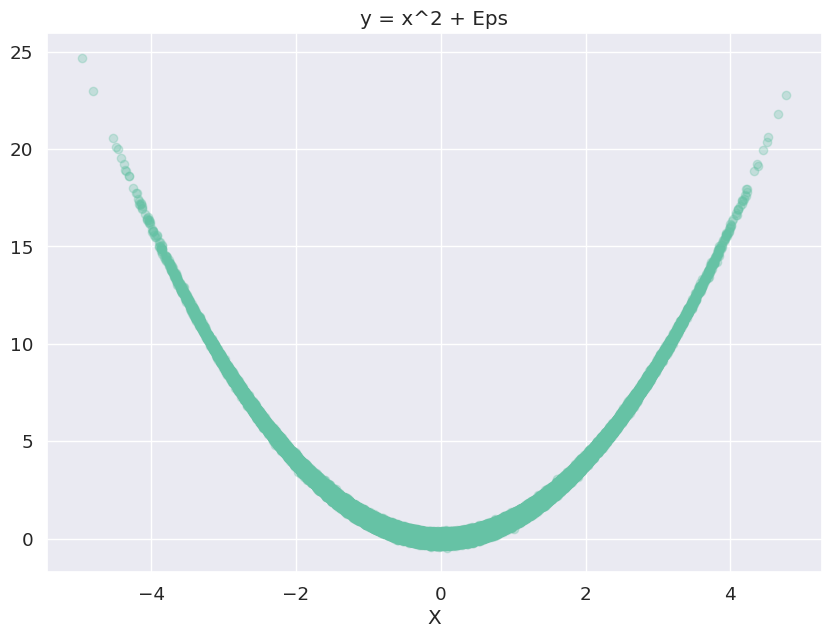

In [4]:
sample_size = int(1e6)
X = sps.norm.rvs(size=(sample_size, 1))

# За функцию возьмем квадрат и добавим шум
y = X[:, 0]**2 + 0.1 * np.random.randn(sample_size)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X_train_torch = torch.tensor(X_train, dtype=torch.float32)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32)
y_test_torch = torch.tensor(y_test, dtype=torch.float32)

assert y.shape == (sample_size,)

plt.figure(figsize=(10, 7))
plt.scatter(X, y, alpha=0.3)
plt.xlabel('X')
plt.title('y = x^2 + Eps')
plt.show()

Обучите нейросеть на этих данных. Используйте код с занятия.

In [5]:

optimizer = torch.optim.SGD(torch_model.parameters(), lr=0.05)
optim_func = nn.MSELoss()

num_iter = 10000

for i in range(num_iter):

    # Forward pass: предсказание модели по тренировочным данным
    y_pred = torch_model(X_train_torch)
    # Вычисление оптимизируемой функции (MSE) по предсказаниям
    loss = optim_func(y_pred[:, 0], y_train_torch)
    if (i % 500 == 0):
        print(i, loss)
    # Bakcward pass: вычисление градиентов оптимизируемой функции
    # по всем параметрам модели
    loss.backward()

    # Оптимизация: обновление параметров по формулам соответствующего
    # метода оптимизации, используются вычисленные ранее градиенты
    optimizer.step()

    # Зануление градиентов
    optimizer.zero_grad()

0 tensor(2.6071, grad_fn=<MseLossBackward0>)
500 tensor(0.8408, grad_fn=<MseLossBackward0>)
1000 tensor(0.3054, grad_fn=<MseLossBackward0>)
1500 tensor(0.1874, grad_fn=<MseLossBackward0>)
2000 tensor(0.1409, grad_fn=<MseLossBackward0>)
2500 tensor(0.1173, grad_fn=<MseLossBackward0>)
3000 tensor(0.1031, grad_fn=<MseLossBackward0>)
3500 tensor(0.0932, grad_fn=<MseLossBackward0>)
4000 tensor(0.0858, grad_fn=<MseLossBackward0>)
4500 tensor(0.0799, grad_fn=<MseLossBackward0>)
5000 tensor(0.0749, grad_fn=<MseLossBackward0>)
5500 tensor(0.0707, grad_fn=<MseLossBackward0>)
6000 tensor(0.0671, grad_fn=<MseLossBackward0>)
6500 tensor(0.0639, grad_fn=<MseLossBackward0>)
7000 tensor(0.0611, grad_fn=<MseLossBackward0>)
7500 tensor(0.0586, grad_fn=<MseLossBackward0>)
8000 tensor(0.0564, grad_fn=<MseLossBackward0>)
8500 tensor(0.0544, grad_fn=<MseLossBackward0>)
9000 tensor(0.0526, grad_fn=<MseLossBackward0>)
9500 tensor(0.0510, grad_fn=<MseLossBackward0>)


Визуализируйте предсказания и посчитайте MSE на тестовой части данных.

0.weight
tensor([[1.9937],
        [1.8395]])
0.bias
tensor([ 3.8492, -3.8257])
2.weight
tensor([[-8.4945,  9.7091]])
2.bias
tensor([8.2024])


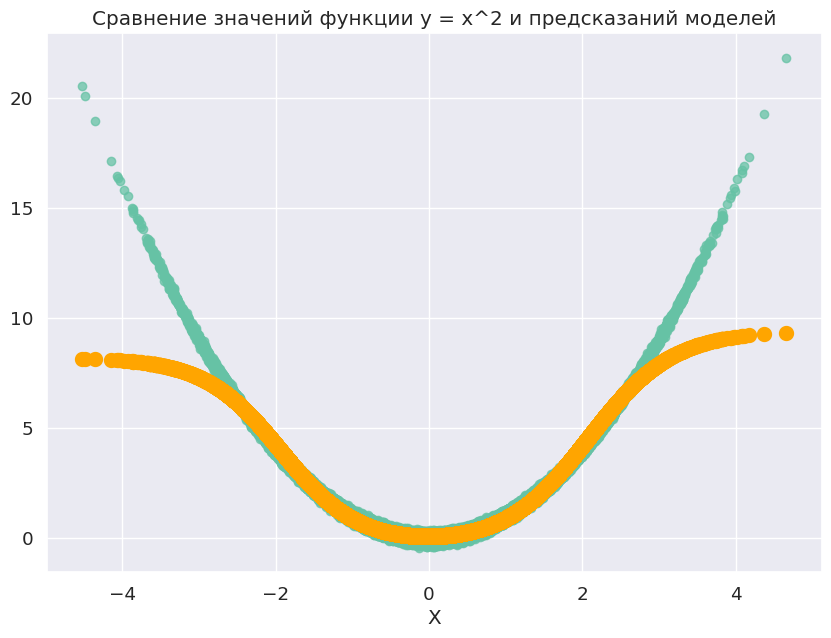

MSE = 0.050


In [6]:
# Выведем обученные параметры
for name, param in torch_model.named_parameters():
    print(name)
    print(param.data)

def show_progress(x, y, y_pred, loss):
    '''
    x, y -- объекты и таргеты выборки;
    y_pred -- предсказания модели;
    loss -- текущее значение ошибки модели.
    '''

    # Открепим переменную от вычислительного графа перед отрисовкой графика
    y_pred = y_pred.detach()

    # Превратим тензор размерности 0 в число
    loss = loss.item()

    # Строим новый график
    plt.figure(figsize=(10, 7))
    plt.scatter(x, y, alpha=0.75)
    plt.scatter(x, y_pred, color='orange', linewidth=5)
    plt.xlabel('X')
    plt.title('Сравнение значений функции y = x^2 и предсказаний моделей')
    plt.show()

    print(f"MSE = {loss:.3f}")

# Посчитаем предсказания модели на тестовых данных
predictions_torch_model = torch_model(X_test_torch)
# Вычисление оптимизируемой функции (MSE) по предсказаниям
loss = optim_func(predictions_torch_model[:, 0], y_test_torch)
show_progress(X_test_torch, y_test_torch, predictions_torch_model[:, 0], loss)

**Вывод:** Я реализовал модель из первого задания с помощью библиотеки PyTorch. При этом пробовал делать только одну итерацию обучения, на тестах получил MSE ~ 5.7-6.0. При количестве итераций 1000 MSE ~ 1.9-2.1, а при 10000 итерациях MSE уже 0.04.

Такие результаты наглядно показывают, как работает обучение при градиентном спуске. По мимо количества итераций можно изменять learning rate, что тоже сильно сказывается на обучении и меняет конечный результат.

---
### <font color="orange"><i>Сложная часть</i></font>

---
### Задача 3.

Теперь реализуйте класс нейронной сети из задачи 1 в стиле scikit-learn, например, см. <a href="https://miptstats.github.io/courses/ad_fivt/task3.html#Задача-4." target="_blank">шаблон класса задачи 4 из задания 3</a>. Предусмотрите возможность обучения по случайным батчам. При реализации можно использовать только библиотеку `numpy`.

In [7]:
class NeuralNetwork:
        def __init__(self, input_size, hidden_size, output_size):
            self.input_size = input_size
            self.hidden_size = hidden_size
            self.output_size = output_size

            # Инициализация параметров сети
            self.W1 = np.random.randn(self.input_size, self.hidden_size)
            self.b1 = np.random.randn(1, self.hidden_size)
            self.W2 = np.random.randn(self.hidden_size, self.output_size)
            self.b2 = np.random.randn(1, self.output_size)

        def sigmoid(self, x):
            return 1 / (1 + np.exp(-x))

        def sigmoid_derivative(self, x):
            return x * (1 - x)

        def forward(self, X):
            self.level1 = np.dot(X, self.W1) + self.b1
            self.actv_func = self.sigmoid(self.level1)
            self.level2 = np.dot(self.actv_func, self.W2) + self.b2
            self.output = self.level2

        def backward(self, X, y, learning_rate):
            m = X.shape[0]
            y = y.reshape(-1, 1)

            # Обратное распространение ошибки
            self.loss = 2 * (self.output - y) / m
            self.dW2 = np.dot(self.actv_func.T, self.loss)
            self.db2 = np.sum(self.loss, axis=0, keepdims=True)
            self.dactv_func = np.dot(self.loss, self.W2.T)
            self.dLevel1 = self.dactv_func * self.sigmoid_derivative(self.actv_func)
            self.dW1 = np.dot(X.T, self.dLevel1)
            self.db1 = np.sum(self.dLevel1, axis=0, keepdims=True)

            # Обновление параметров
            self.W1 -= learning_rate * self.dW1
            self.b1 -= learning_rate * self.db1
            self.W2 -= learning_rate * self.dW2
            self.b2 -= learning_rate * self.db2


        def fit(self, X, y, epochs=1000, batch_size=256, learning_rate=0.01, eps=0.03):
            for epoch in range(epochs):
                # Перемешивание данных
                indices = np.random.permutation(X.shape[0])
                X_shuffled = X[indices]
                y_shuffled = y[indices]

                # Обучение по батчам
                for i in range(0, X.shape[0], batch_size):
                    X_batch = X_shuffled[i:i+batch_size]
                    y_batch = y_shuffled[i:i+batch_size]

                    # Прямой проход
                    self.forward(X_batch)

                    # Обратный проход
                    self.backward(X_batch, y_batch, learning_rate)

                # Выводим значение функции потерь каждые 100 эпох
                if (epoch+1) % 100 == 0:
                    self.forward(X)
                    loss = np.mean(np.square(self.output[:, 0] - y))
                    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss:.4f}')
                    if (loss < eps):
                        print("Модель обучена")
                        break

        def predict(self, X):
            self.forward(X)
            return self.output


Обучите нейронную сеть на рассмотренных ранее данных, а также простую линейную регрессию. Для линейной регрессии стоит взять реализацию из `sklearn`. Сравните эту нейросеть, линейную регрессию и pytorch-сеть из задачи 2.

In [8]:
my_model = NeuralNetwork(1, 2, 1)
my_model.fit(X_train, y_train, epochs = 10000)

linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)

Epoch [100/10000], Loss: 0.0190
Модель обучена


LinearRegression()

На данном этапе можно сравнить только время обучения моделей: линейная регрессия самая быстрая, так как у нее сильно меньше обучаемых параметров. В скорости моя модель обучается сильно быстрее (порядка 15 секунд против ~4 минут) до одинаковой точности. Этого я добился за счет использования стохастического градиентного спуска, а не обычного (в PyTorch почему-то обычный GD называется SGD, хотя на тестах он показывает время как модель, которая использует весь датасет, а также нет никаких параметров, которые задавали бы размер батча, поэтому такой вывод). Ещё показателем становится количество пройденный эпох, которое у моей модели в 100 раз меньше, чем у PyTorch-сети. Этого можно добиться опять же за счет SGD + перемешивание данных. Сравнение данных сетей - это отличный пример для теории из третьего пункта первого задания.

Визуализируйте предсказания данных моделей и посчитайте MSE на тестовой части данных.

My model loss on tests: 0.0188
Linear regression loss on tests: 1.9955
PyTorch model loss on tests: 0.0495


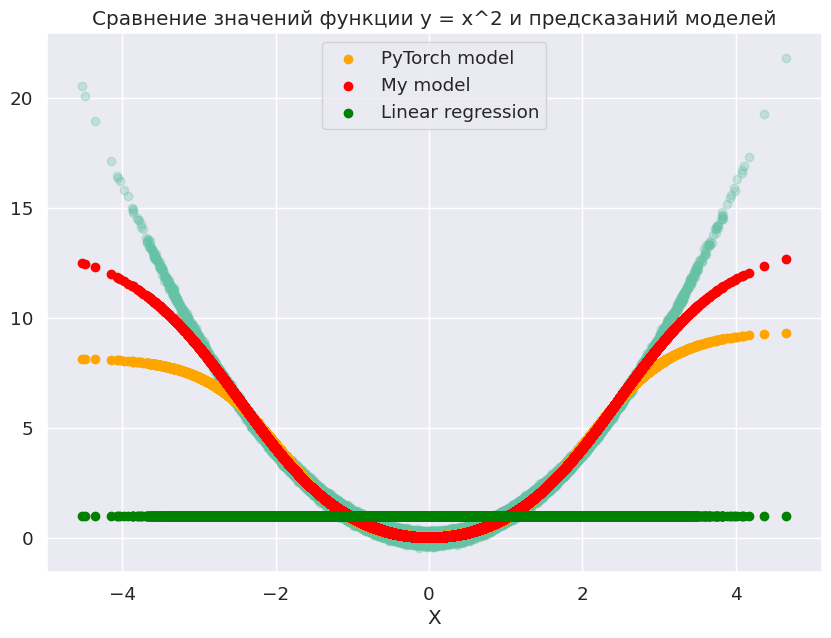

In [9]:
predictions_my_model = my_model.predict(X_test)
mse = np.mean(np.square(predictions_my_model[:, 0] - y_test))

print(f'My model loss on tests: {mse:.4f}')

predictions = linear_regression.predict(X_test)
mse = np.mean(np.square(predictions - y_test))

print(f'Linear regression loss on tests: {mse:.4f}')

mse = np.mean(np.square(predictions_torch_model[:, 0].detach().numpy() - y_test))

print(f'PyTorch model loss on tests: {mse:.4f}')

plt.figure(figsize=(10, 7))
plt.scatter(X_test, y_test, alpha=0.3)
plt.scatter(X_test, predictions_torch_model[:, 0].detach(), color='orange', linewidth=1, label='PyTorch model')
plt.scatter(X_test, predictions_my_model, color='red', linewidth=1, label='My model')
plt.scatter(X_test, predictions, color='green', linewidth=1, label='Linear regression')
plt.xlabel('X')
plt.title('Сравнение значений функции y = x^2 и предсказаний моделей')
plt.legend()
plt.show()


Из графика видно, что линейная регрессия совсем бесполезна на квадратичной функции, а двухслойная модель из линейных слоев достаточно точно приближает значения. Моя модель имеет немного меньше ошибку, поэтому и на графике выглядит лучше.

Повторите вычисления для другой нелинейной функции $y(x)$.

Epoch [100/4000], Loss: 0.1890
Epoch [200/4000], Loss: 0.1605
Модель обучена
0 tensor(14.5529, grad_fn=<MseLossBackward0>)
500 tensor(7.2684, grad_fn=<MseLossBackward0>)
1000 tensor(2.8425, grad_fn=<MseLossBackward0>)
1500 tensor(1.9793, grad_fn=<MseLossBackward0>)
2000 tensor(1.5853, grad_fn=<MseLossBackward0>)
2500 tensor(1.3413, grad_fn=<MseLossBackward0>)
3000 tensor(1.1720, grad_fn=<MseLossBackward0>)
3500 tensor(1.0468, grad_fn=<MseLossBackward0>)
Loss on tests: 0.1711
Loss on tests: 6.0533


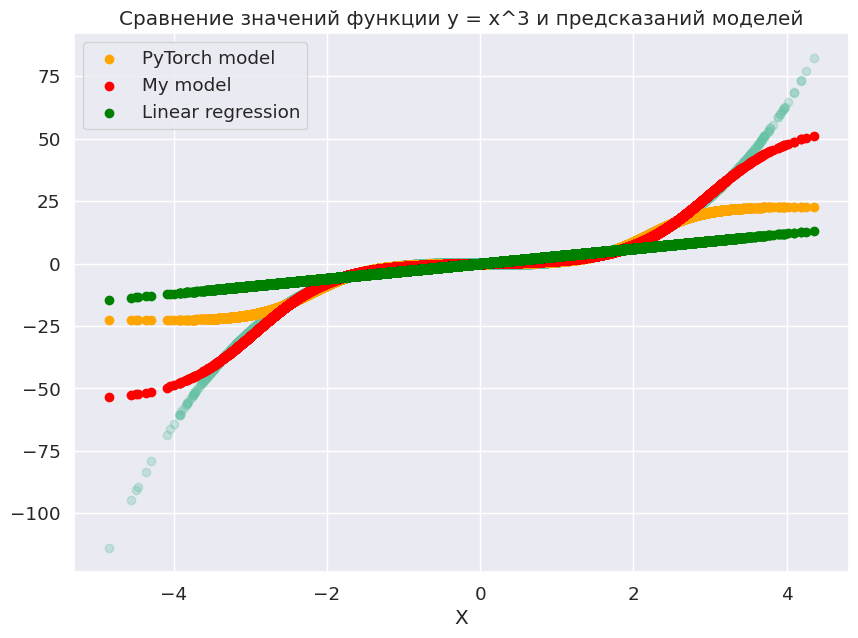

In [10]:
sample_size = int(1e6)
X = sps.norm.rvs(size=(sample_size, 1))

# За функцию возьмем куб и добавим шум
y = X[:, 0]**3 + 0.1 * np.random.randn(sample_size)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.25, random_state=42)

X_train_torch2 = torch.tensor(X_train2, dtype=torch.float32)
X_test_torch2 = torch.tensor(X_test2, dtype=torch.float32)
y_train_torch2 = torch.tensor(y_train2, dtype=torch.float32)
y_test_torch2 = torch.tensor(y_test2, dtype=torch.float32)

# Создаем PyTorch модель
torch_model2 = nn.Sequential(
    # кол-во признаков во входном слое 1, в выходном 2
    nn.Linear(in_features=1, out_features=2),
    nn.Sigmoid(),
    # кол-во признаков во входном слое 2, в выходном 1
    nn.Linear(in_features=2, out_features=1)
)

# Создаем модель написанного класса
my_model2 = NeuralNetwork(1, 2, 1)

# Создаем модель линейной регрессии
linear_regression2 = LinearRegression()

# Обучаем все модели
num_iter = 4000
my_model2.fit(X_train2, y_train2, epochs = num_iter, eps=0.17)

linear_regression2.fit(X_train2, y_train2)

optimizer = torch.optim.SGD(torch_model2.parameters(), lr=0.05)
optim_func = nn.MSELoss()

for i in range(num_iter):
    # Forward pass: предсказание модели по тренировочным данным
    y_pred = torch_model2(X_train_torch2)
    # Вычисление оптимизируемой функции (MSE) по предсказаниям
    loss = optim_func(y_pred[:, 0], y_train_torch2)
    if (i % 500 == 0):
        print(i, loss)
    # Bakcward pass: вычисление градиентов оптимизируемой функции
    # по всем параметрам модели
    loss.backward()

    # Оптимизация: обновление параметров по формулам соответствующего
    # метода оптимизации, используются вычисленные ранее градиенты
    optimizer.step()

    # Зануление градиентов
    optimizer.zero_grad()


# Делаем предсказания
predictions_my_model = my_model2.predict(X_test2)
mse = np.mean(np.square(predictions_my_model[:, 0] - y_test2))

print(f'Loss on tests: {mse:.4f}')

predictions = linear_regression2.predict(X_test2)
mse = np.mean(np.square(predictions - y_test2))

print(f'Loss on tests: {mse:.4f}')

predictions_torch_model = torch_model2(X_test_torch2)

plt.figure(figsize=(10, 7))
plt.scatter(X_test2, y_test2, alpha=0.3)
plt.scatter(X_test2, predictions_torch_model[:, 0].detach(), color='orange', linewidth=1, label='PyTorch model')
plt.scatter(X_test2, predictions_my_model, color='red', linewidth=1, label='My model')
plt.scatter(X_test2, predictions, color='green', linewidth=1, label='Linear regression')
plt.xlabel('X')
plt.title('Сравнение значений функции y = x^3 и предсказаний моделей')
plt.legend()
plt.show()

**Вывод:**
в заданиях мы рассмотрели двухслойную нейросеть и разобрали, как её эффективно обучать. Дальше мы сравнили две нейросети и линейную регрессию на двух разных датасетах. Результат показал, что линейная регрессия бесполезна на нелинейных функциях, а вот даже двухслойные сети могут хорошо приближать данные.

Еще один важный вывод: важно правильно подбирать подход к обучению и ограничения на обучение, чтобы делать его максимально эффективно (сравнение GD и SGD).